# package setup

In [ ]:
# for analysis
!pip install --upgrade scipy
!pip install plotly_express
!pip install --upgrade gensim

In [ ]:
# for textual extraction
!pip install pdf2image
!apt-get install poppler-utils
!pip install pytesseract

In [ ]:
import os
from pdf2image import convert_from_path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pytesseract
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from pandas import DataFrame as df
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from ssl import ALERT_DESCRIPTION_BAD_CERTIFICATE_HASH_VALUE
import pandas as pd
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation as LDA, NMF
from gensim.models import word2vec
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
from gensim.models import word2vec
from sklearn.manifold import TSNE
import plotly_express as px
import plotly_express as px
from scipy.linalg import eigh
from scipy.linalg import norm
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist
from sklearn.neighbors import KernelDensity as KDE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import nltk, os, re, glob

# Get textual information from pdf

use pyteseract to convert pdf files into textual information 


In [ ]:
# convert pdf to images to txt information
def pdf2txt( pdf_dir ):
  # pdf to pngs
  pages = convert_from_path(pdf_dir, 350)
  if len(pdf_dir.split('/')) == 1:
    pdf_name = pdf_dir.split('.')[0]
  else: 
    pdf_name = pdf_dir.split('/')[-1].split('.')[0]

  pages_dir = os.path.join(pdf_name) + '_pages'
  if os.path.isdir(pages_dir):
    print( pages_dir, 'exists')
  else: 
    print( pages_dir, 'not exist')
    os.mkdir( pages_dir )

  page_names = []
  for idx, page in enumerate(pages):
    page_name = os.path.join(pages_dir, pdf_name + '_' + str(idx) + '.jpg' )
    page.save( page_name, 'JPEG' )
    page_names.append(page_name)

  # parse each page  
  text_file = open( os.path.join( pages_dir, pdf_name + '.txt'), 'w' )
  for page_name in page_names:
    print( page_name )
    extractedInfo = pytesseract.image_to_string( Image.open(page_name) )
    text_file.write( extractedInfo )
  text_file.close()

In [ ]:
for i in range(10,17):
  pdf2txt( str(i) + '.pdf' )
for i in range(1, 17):
  src = os.path.join( str(i) + '_pages', str(i) + '.txt' )
  tgt = os.path.join( 'converted', str(i) + '.txt')
  os.rename( src, tgt ) 

!zip -r converted.zip ./converted

# custom functions

## Data parsing

In [114]:
def formatParag(parag):
  line = ''
  if len(parag) > 150:
    numParts = len(parag) // 150
    remainder = len(parag) % 150
    for idx in range(numParts):
      line += parag[idx * 150: idx * 150 + 150] + '\n'
    if remainder != 0: 
      line += ' ' + parag[-remainder:]
  else: 
    line = parag
  return line

In [115]:
'''
8 © 2018 Acta Materialia Inc. Published by Elsevier Ltd. All rights reserved.
38 * Corresponding author.
39 E-mail address: zhjwang@nwpu.edu.cn (Z. Wang).
41 https://doi.org/10.1016/j.scriptamat.2018.12.022
42 1359-6462/© 2018 Acta Materialia Inc. Published by Elsevier Ltd. All rights reserved.
'''

spcChars = ['\u00A9', 'corresponding author', 'e-mail', 'https',]
figures = ['fig', 'figure', 'fig.', 'figure.']
tables = ['table']
eqs = ['eq.', 'eq', 'eqs.', 'eqs']
def check_specialChars( lines ): 
  lines = lines.lower()
  for spc in spcChars: 
    if spc in lines: 
      print( '[NOT TEXT] special character:', lines )
      return False

  # if lines.split(' ')[0] in figures: 
  #   return True
  # if lines.split(' ')[0] in tables:
  #   return True

  return True

In [116]:
# Z. Wang et al. / Scripta Materialia 162 (2019) 468-471 469
def checkReference( txt ):
  txt = txt.lower()
  if re.search( regex_ref_2k, txt ) or re.search( regex_ref_1k, txt ):
    print( '[NOT TEXT] reference:', txt )
    return False
  return True

def checkInlineReference(txt):
  txt = txt.lower()
  if re.search(ref_regex, txt):
    print( '[NOT TEXT] inline reference:', txt)
    return False
  return True

def dealInlineReference(txt):
  idx = re.search(ref_regex, txt)
  idx, idx_end = idx.span()
  new_txt = re.sub(ref_regex, '', txt)
  if new_txt.strip() == '.':
    return '.'

  print( new_txt )
  if idx == 0:
    new_txt = new_txt[idx_end-1:]
  else:   
    new_txt = new_txt[:idx-1] + new_txt[idx:]
  print( new_txt )
  return new_txt

def checkEquation(txt):
  txt = txt.lower()
  if re.search(eq_regex, txt):
    print( '[NOT TEXT] equation:', txt)
    return False
  return True 

def checkEquationWord(txt):
  txt = txt.lower()
  if re.search(eqWord_regex, txt):
    print('[irrelevant] equation:', txt)
    return False
  return True 

def dealEquation(txt):
  idx = re.search(eq_regex, txt)
  idx, idx_end = idx.span()
  new_txt = re.sub(eq_regex, '', txt)
  print( new_txt )
  if idx == 0:
    new_txt = new_txt[idx_end-1:]
  else:   
    new_txt = new_txt[:idx-1] + new_txt[idx:]
  print( new_txt )

  if not checkEquationWord(new_txt):
    idx = re.search(eqWord_regex, new_txt)
    idx, idx_end = idx.span()
    new_txt = re.sub(eqWord_regex, '', new_txt)
    print( new_txt )
    if idx == 0:
      new_txt = new_txt[idx_end-1:]
    else:   
      new_txt = new_txt[:idx-1] + new_txt[idx:]
    print( new_txt )

  return new_txt

In [117]:
def checkNewLine(txt):
  splits = txt.split('\n')
  if len( splits ) != 2:
    return False
  a, b = splits
  if re.search( '^( {0,})$', a ) and re.search( '^( {0,})$', b):
    return True
  return False

def makeParagraph(arr):
  paragraph = []
  checks = [False] * len(arr)
  for idx, line in enumerate(arr):
    if idx == len(arr) - 1:
      line = line.strip()
      paragraph.append(line)
      break
    
    line = line.strip()
    nextLine = arr[idx + 1].strip()
    if line[-1] == '-' and not nextLine[0].isupper(): 
      line = line[:-1]
      checks[idx] = True
      
    paragraph.append(line)

  paragraph_sentence = ''
  for (line, check) in zip(paragraph, checks):
    if check:
      paragraph_sentence += line + ''
    else: 
      paragraph_sentence += line + ' '

  # return ' '.join(paragraph)
  return paragraph_sentence.strip()

In [118]:
def countNumbers(txt):
  words = txt.split( ' ' )
  numWords = len(words)
  numChars = len(txt)

  numNums = 0
  numNums_chars = 0
  for word in words:
    if word.isnumeric() or re.search(num_regex, word):
      numNums += 1
      numNums_chars += len(word)
    
  if numNums > (numWords * .5) or numNums_chars > (numChars * .4):
    print( numNums, '/', numWords, ';', numNums_chars, '/', numChars, ':', words)
    return True
  return False

In [119]:
def checkFigure(parg):
  parg = parg.strip()
  seps = re.split( fig_regex, parg )
  seps = [x for x in seps if len(x) != 0]
  if len(seps) == 1: 
    return True
  if len(seps) > 2:
    return True

  sents = re.split( sent_regex, seps[0] ) 
  actual_line_ct = 0
  num_lines = len(sents)
  for line in sents:
    line = line.strip()
    if not countNumbers(line):
      actual_line_ct += 1
  
  if actual_line_ct > num_lines * 0.25:
    print( '', '[check] figure - False:', actual_line_ct, '/', num_lines )
    return False
  else: 
    print( '', '[check] figure - True:', actual_line_ct, '/', num_lines )
    return True

def eqCts(sent):
  cts = 0
  cts += len( sent.split('=') ) - 1
  cts += len( sent.split('+') ) - 1
  cts += len( sent.split('-' ) ) - 1
  cts += len( sent.split('*' ) ) - 1
  cts += len( sent.split('/' ) ) - 1
  cts += len( sent.split('%' ) ) - 1
  cts += len( sent.split( '<' ) ) - 1
  cts += len( sent.split( '>' ) ) - 1  
  cts += len( sent.split('&') ) - 1
  cts += len( sent.split('~') ) - 1

  return cts

In [120]:
ref_regex = '\[([0-9]+|([0-9]+|\, {0,})+)\]'
eq_regex = '\(([0-9]+|([0-9]+|\, {0,})+)\)'
eqWord_regex = '(?i)(eq.|eq|eqs.|eqs)'
eq_regex = '\(([0-9]+|([0-9]+|\, {0,})+)\)'

regex_ref_2k = '\([2][0][0-2][0-9]\)'
regex_ref_1k = '\([1][7-9][0-9][0-9]\)'
equt_regex = '\([0-9]+\)'
nonEnglish_regex = '^[^A-Za-z][^A-Za-z0-9/()\-]*'
multispace_regex = ' {2,}'

ref_regex = '\[([0-9]+|([0-9]+|\, {0,})+)\]'
fig_regex = 'Fig. [0-9]+\.'
sent_regex = '\. '

## Others

In [154]:
def getTFIDF(bow, tf_method):
    DTCM = bow.n.unstack()
    # check and deal with the tf_method
    if tf_method == 'sum':
        TF = DTCM.T / DTCM.T.sum()
    elif tf_method == 'max':
        TF = DTCM.T / DTCM.T.max()
    elif tf_method == 'log':
        TF = np.log10(DTCM.T + 1)
    elif tf_method == 'raw':
        TF = DTCM.T
    elif tf_method == 'bool':
        TF = DTCM.T.astype('bool') #.astype('int')
    else:
        raise ValueError('tf_method:' + tf_method + ' is not valid')
    TF = TF.T

    DF = DTCM.count()
    N = DTCM.shape[0]
    IDF = np.log10(N/DF)
    TFIDF = TF * IDF
    
    return TF, DF, IDF, TFIDF

def getBOW(data, bagChoice):
    OHCO = ['doc_id', 'parg_num', 'sent_num', 'token_num']
    if not isinstance(bagChoice, list): # check the bagChoice is a list type
        raise ValueError( 'bagChoice:' + ' has to be a OHCO list')
    if len(OHCO) != len( set(OHCO) | set(bagChoice) ): # check the bagChoice is part of the OHCO level
        raise ValueError( 'bagChoice:' + ' has to be a subset of the OHCO list - ' + str(OHCO) )
    BOW = data.groupby( bagChoice+['term_str']).term_str.count().to_frame('n')
    return BOW

In [155]:
def hca(sims, title="My Dendrogram", linkage_method='weighted', color_thresh=None, figsize=(7, 7)):

    tree = sch.linkage(sims, method=linkage_method)
    labels = LIB.label.values
    if not color_thresh:
        color_thresh = pd.DataFrame(tree)[2].median()
    
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)
    fig.suptitle(title, fontsize=20)

In [173]:
class HAC:
    """
    Takes an arbitrary vector space and represents it 
    as a hierarhical agglomerative cluster tree. 
    The number of observations should be sufficiently 
    small to allow being plotted.

    Attributes:
        w (int): The width of the figure in inches.
        label_size (int): The font size of the labels in points.
        orientation (str): The orientation of the figure; 'top', 'bottom', 'left', 'right'. Defaults to 'left'.
        dist_measure (str): The distance measure to use; braycurtis, canberra, chebyshev, cityblock, correlation, 
            cosine, dice, euclidean, hamming, jaccard, jensenshannon, kulsinski, kulczynski1, mahalanobis, matching, 
            minkowski, rogerstanimoto, russellrao, seuclidean, sokalmichener, sokalsneath, sqeuclidean, yule. 
            Defaults to euclidean.
        linkage_method (str): The linkage method to use; single, complete, average, weighted, centroid, median, ward
            Defaults to ward.
        norm_type (str): The vector normalization type; l1, l2, max. Defaults to l2.
        color_thresh (float): The threshhold at which to apply coloring in the dendropgram. Defaults to None.
    """

    w:int = 10
    label_size:int = 14
    orientation:str = 'left'
    dist_metric:str = 'euclidean' 
    linkage_method:str = 'ward' 
    norm_type:str = 'l2' 
    color_thresh:float = None
    
    def __init__(self, X, labels=None):
        self.X = X
        self.h = X.shape[0]
        if labels:
            self.labels = labels            
        else:
            self.labels = X.index.tolist()

    def get_sims(self):
        self.SIMS = pdist(normalize(self.X, norm=self.norm_type), metric=self.dist_metric)

    def get_tree(self):
        self.TREE = sch.linkage(self.SIMS, method=self.linkage_method)        
        
    def plot_tree(self):
        if not self.color_thresh:
            self.color_thresh = df(self.TREE)[2].median()
        plt.figure()
        plt.subplots(figsize=(self.w, self.h / 3))
        sch.dendrogram(self.TREE, 
            labels=self.labels, 
            orientation=self.orientation,
            count_sort=True,
            distance_sort=True,
            above_threshold_color='.75',
            color_threshold=self.color_thresh);
        plt.tick_params(axis='both', which='major', labelsize=self.label_size)
        
    def plot(self):
        self.get_sims()
        self.get_tree()
        self.plot_tree()


In [ ]:
class TopicModel():            

    """
    A class to convert a BOW table into a topic model consisting of THETA, PHI, and TOPIC tables.
    Attributes:
        bow_count_col (str): The name of the token count column in the BOW table. Defaults to 'n'.
        n_term (int): The number of vocabalary terms to use in the topic model. Defaults to None.
        n_topics (int): The number of topics to generate. Defaults to 20.
        n_top_terms (int): The number of top terms to use to represent each topic. Will compute based on entropy if no value given. Defaults to None.
        engine_type (str): The topic modeling engine to use. May be 'LDA' or 'NMF'. Defaults to 'LDA'.
        alpha (float) = The document-topic prior, e.g. .1.  Defaults to None.
        beta (float) = The topic-term prior, e.g. .01.  Defaults to None.
        
        # LDA Params
        max_iter:int = 20
        learning_offset:float = 50.
        random_state:int = 0
        
        # NMF Params
        nmf_init:str = 'nndsvd'
        nmf_max_iter:int = 1000
        nmf_random_state:int = 1

        kw = {} # Extra parameters

    """

    # General
    bow_count_col:str = 'n'
    n_terms:int = None
    n_topics:int = 20
    n_top_terms:int = None
    engine_type:str = 'LDA' # Also NMF
    alpha:float = None # doc_topic_prior
    beta:float = None  # topic_word_prior
    
    # LDA Params
    max_iter:int = 20
    learning_offset:float = 50.
    random_state:int = 0
    
    # NMF Params
    nmf_init:str = 'nndsvd'
    nmf_max_iter:int = 1000
    nmf_random_state:int = 1

    kw = {} # Extra parameters
    
    def __init__(self, BOW:pd.DataFrame):
        """
        Initialize by passing a bag-of-words table with an OHCO index and 'n' feature of word counts.
        """
        self.BOW = BOW
        
    def create_X(self):
        
        # Convert BOW to DTM (X)
        X = self.BOW[self.bow_count_col].unstack(fill_value=0)

        # Reduce feature space if asked
        V = X[X > 0].sum().to_frame('df')
        if self.n_terms:
            V['idf'] = np.log2(len(X)/V.df)
            V['dfidf'] = V.df * V.idf
            SIGS = V.sort_values('dfidf', ascending=False).head(self.n_terms).index
            self.X = X[SIGS]
        else:
            self.X = X
        self.V = V        
        
    def get_model(self):
        
        if self.engine_type == 'LDA':
            self.engine = LDA(n_components=self.n_topics, 
                                max_iter=self.max_iter, 
                                doc_topic_prior=self.alpha,
                                topic_word_prior=self.beta,
                                learning_offset=self.learning_offset, 
                                random_state=self.random_state,
                                **self.kw)

        elif self.engine_type == 'NMF':
            self.engine = NMF(n_components=self.n_topics, 
                                max_iter=self.nmf_max_iter,
                                init=self.nmf_init, 
                                random_state=self.nmf_random_state, 
                                **self.kw)
                
        self.THETA = pd.DataFrame(self.engine.fit_transform(self.X.values), index=self.X.index)
        self.THETA.columns.name = 'topic_id'
        
        self.PHI = pd.DataFrame(self.engine.components_, columns=self.X.columns)
        self.PHI.index.name = 'topic_id'
        self.PHI.columns.name = 'term_str'
        
        self.TOPIC = self.PHI.sum(1).to_frame('phi_sum')
        self.TOPIC['theta_sum'] = self.THETA.sum()

    def describe_topics(self):
        
        # Compute topic entropy over PHI to get n for top terms
        PHI_P = (self.PHI.T / self.PHI.T.sum())
        PHI_I = np.log2(1/PHI_P)
        self.TOPIC['h'] = round((PHI_I * PHI_P).sum().sort_values(ascending=False), 2)
        if not self.n_top_terms:
            self.n_top_terms = round(self.TOPIC.h.mean())

        # Compute relevant terms
        self.get_relevant_terms(0)
        
        # Get top terms
        self.TOPIC['top_terms'] = self.PHI.apply(lambda x: ' '.join(x.sort_values(ascending=False).head(self.n_top_terms).index), 1)        
        self.TOPIC['label'] = self.TOPIC.apply(lambda x: f"{x.name}: {x.top_terms_rel}", 1)
        

    def get_relevant_terms(self, 𝜆 = .5):
        """
        Compute relevance of topic terms as defined by Sievert and Shirley 2014.
        C. Sievert and K. Shirley, “LDAvis: A Method for Visualizing and Interpreting Topics,” 
        in Proceedings of the workshop on interactive language learning, visualization, and interfaces, 2014, pp. 63–70.
        """
        Ptw = self.PHI.apply(lambda x: x / x.sum(), 1) # L1 norm of PHI rows, i.e. p(w|t)
        Pw = self.PHI.sum() / self.PHI.sum().sum() # Marginal probs of terms in PHI, i.e. p(w)
        self.REL = 𝜆 * np.log2(Ptw) + (1-𝜆) * np.log2(Ptw / Pw)
        self.TOPIC['top_terms_rel'] = self.REL.apply(lambda x: ' '.join(x.sort_values(ascending=False).head(self.n_top_terms).index), 1)

    def get_model_stats(self):
        self.entropy = self.TOPIC.h.sum()
        self.redundancy = 1 - self.entropy / np.log2(self.n_topics)
    
    def get_doc_stats(self):
        self.DOC = (self.THETA.T * np.log2(1/self.THETA.T)).sum().to_frame('entropy')
        self.DOC['max_topic'] = self.THETA.idxmax(1)
        
    def plot_topics(self):
        self.TOPIC.sort_values('theta_sum', ascending=True)\
            .plot.barh(y='theta_sum', x='label', figsize=(5, self.n_topics/2))

In [181]:
class W2V():
    """
    Apply word2vec to a TOKEN table with OHCO index. Returns a word embedding model and a tSNE projection, 
    as well as method to visualize the results. Assumes that TOKEN is annotated with POS column called 'pos'.
    """
    # Arguments for Gensim's word2vec()
    w2v_args = dict(
        min_count = 20,
        vector_size = 100,
        window = 2
    )
    
    # Arguments for SciKit Learn's TSNE()
    tsne_args = dict(
        learning_rate = 200.,
        perplexity = 40,
        n_components = 2,
        init = 'random',
        n_iter = 1000,
        random_state = 23    
    )
    

    def __init__(self, tokens, window_bag, doc_bag):
        """
        Initialize object.
        Arguments:
            tokens (pd.DataFrame): An ETA compliant token table.
            window_bag (list): OCHO slice for bag to use for window. Should be sentences.
            doc_bag (list): OCHO slice for bag to use to compute term significance, e.g. OHCO slide for chapters.
        """
        self.TOKENS:pd.DataFrame = tokens
        self.OHCO = self.TOKENS.index.names
        self.WBAG = window_bag 
        self.DOCBAG = doc_bag 
        print("W2V Bag:", self.WBAG[-1])
        print("DOC Bag:", self.DOCBAG[-1])
        
    def generate_model(self):
        """
        Run all the methods to generate both the word embeddings and the tSNE projection.
        """
        print("Extracting vocabulary")
        self._extract_vocab()
        print('Gathering sentences')
        self._get_sents()
        print("Learning word vectors")
        self._get_model()
        print("Estimating tSNE coordinates")
        self._get_tsne_coords()
        print("Done", u'\u2713')
        
    def _extract_vocab(self):
        """
        Extract vocabulary table VOCAB form TOKENS and compute pos_max, pos_group, and dfidf for terms.
        """
        self.VOCAB = self.TOKENS.term_str.value_counts().to_frame('n')
        self.VOCAB.index.name = 'term_str'
        
        # Todo: Check if TOKENS has `pos`
        self.VOCAB['pos_max'] = self.TOKENS.value_counts(['term_str','pos']).unstack().idxmax(1)
        self.VOCAB['pos_group'] = self.VOCAB.pos_max.str.slice(0,2)
        
        # Add DFIDF 
        self.DOCS = self.TOKENS.groupby(self.DOCBAG +['term_str']).term_str.count()\
            .unstack(fill_value=0).astype('bool').astype('int')
        self.VOCAB['df'] = self.DOCS.sum()
        N = len(self.DOCS)
        self.VOCAB['dfidf'] = self.VOCAB.df * np.log2(N/self.VOCAB.df)
        
    def _get_sents(self):
        """
        Gather senteces (window bags) into lists of tokens for use by Gensim.
        """
        self.SENTS = self.TOKENS.groupby(self.WBAG)\
            .term_str.apply(lambda  x:  x.tolist())\
            .reset_index()['term_str'].tolist()
        
    def _get_model(self):
        """
        Learn word embeddings from SENTS.
        """
        self.model = word2vec.Word2Vec(self.SENTS, **self.w2v_args)
        self.VEC = pd.DataFrame(self.model.wv.get_normed_vectors(), 
                                    index=self.model.wv.index_to_key)
        self.VEC.index.name = 'term_str'
        self.VEC = self.VEC.sort_index()
        
    def _get_tsne_coords(self):
        """
        Project embeddings onto 2D tSNE space.
        """
        self.tsne_engine = TSNE(**self.tsne_args)
        self.tsne_model = self.tsne_engine.fit_transform(self.VEC)        
        self.TSNE = pd.DataFrame(self.tsne_model, columns=['x','y'], index=self.VEC.index)\
                .join(self.VOCAB, how='left')[['x','y','n','dfidf','pos_group']]
        
    def plot_tsne(self, n=1000, method='dfidf'):
        """
        Plot tSNE coordinates. 
        Arguments:
            n (int): Number of terms to plot. Not used if method = 'all'. Be careful with that.
            method (str): Choose whether and how to filter terms to plot. 
                'dfidf' top n terms by dfidf; 'sample' n terms by sample; 'all' all terms. 
                Defaults to 'dfidf.'
        """
        if method == 'dfidf':
            X = self.TSNE.sort_values('dfidf', ascending=False).head(n).reset_index()
        elif method == 'sample':
            if n < len(self.TSNE):
                X = self.TSNE.sample(n).reset_index()
            else:
                X = self.TSNE.reset_index()
        elif method == 'all':
            X = self.TSNE.reset_index()
        else:
            raise ValueError("Unknown method. Use 'difidf' or 'sample'.")        
        px.scatter(X, 'x', 'y', 
                   text='term_str', 
                   color='pos_group', 
                   hover_name='term_str',
                   size='dfidf',
                   height=1000, width=1200)\
            .update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center').show()
        
    def complete_analogy(self, A, B, C, n=2):
        """
        Estimate the fourth term of an analogy. Passes arguments to model.wv.most_similar(positive=[B, C], negative=[A]).
        See document for Gensim's model.wv.most_similar() for more info.
        """
        try:
            cols = ['term', 'sim']
            return pd.DataFrame(self.model.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
        except KeyError as e:
            print('Error:', e)
            return None

    def get_most_similar(self, positive, negative=None):
        """
        Get the most similar terms for a given term. Passes arguments to model.wv.most_similar(positive, negative).
        See document for Gensim's model.wv.most_similar() for more info.
        """
        return pd.DataFrame(self.model.wv.most_similar(positive, negative), columns=['term', 'sim'])        

# Data processing

Process noisy / erroneous converted text file into a correct representation

In [ ]:
# iterate over different files
filename = '0'
with open ( filename + '.txt') as f:
  lines = f.readlines()

In [ ]:
# process 1: remove 1) acknowledgement, 2) reference, 3) emails, author information
trimed_lines = []
added_ct = 0
for x in range(len(lines)):
  line = lines[x]
  print( x, line )
  if line.lower().strip() in ['acknowledgements', 'acknowledgement', 'references', 'reference', 'acknowledgments']: 
    break

  go = check_specialChars(line)
  if not go:
    # print( '[skipped]:', line ) 
    continue
  
  go = checkReference(line)
  if not go: 
    # print( '[skipped]:', line ) 
    continue

  if not checkInlineReference(line): 
    line = dealInlineReference(line)
    if line == '.':
      trimed_lines[-1] = trimed_lines[-1].strip() + '.' + '\n'
      continue
    print( '[good]:', line )
  if not checkEquation(line):
    line = dealEquation(line)
    print( '[good]:', line )

  trimed_lines.append(line)

0 High-entropy alloys are random alloys with five or more components, often near equi-composition, that often exhibit excellent

1 mechanical properties. Guiding the design of new materials across the wide composition space requires an ability to compute

2 necessary underlying material parameters via ab initio methods. Here, density functional theory is used to compute the elemental

3 misfit volumes, alloy lattice constant, elastic constants, and stable stacking fault energy in the fcc noble metal RhlrPdPtNiCu. These

4 properties are then used in a recent theory for the temperature and strain-rate dependent yield strength. The parameter-free

5 prediction of 583 MPa is in excellent agreement with the measured value of 527 MPa. This quantitative connection between alloy

6 composition and yield strength, without any experimental input, motivates this general density functional theory-based

7 methodological path for exploring new potential high-strength high-entropy alloys, in this a

In [ ]:
# process 2: removes multiple lines between paragraphs
trimed_lines2 = []

idx = 0
while True:
  if idx == len(trimed_lines) - 1: 
    break
  curr_line = trimed_lines[idx]
  next_line = trimed_lines[idx + 1]
  print( idx, curr_line )
  trimed_lines2.append(curr_line)
  ct = 1
  if checkNewLine(curr_line) and checkNewLine(next_line): # multiple lines ongoing
    endParagraph = False  
    print( '', 'multiple lines:', curr_line)
    while True: 
      next_line = trimed_lines[idx + ct]
      print( '', '', next_line)
      if not checkNewLine(next_line): 
        break
      ct += 1
    print( 'start', idx )
    print( 'next line', idx + ct )
  idx += ct

0 High-entropy alloys are random alloys with five or more components, often near equi-composition, that often exhibit excellent

1 mechanical properties. Guiding the design of new materials across the wide composition space requires an ability to compute

2 necessary underlying material parameters via ab initio methods. Here, density functional theory is used to compute the elemental

3 misfit volumes, alloy lattice constant, elastic constants, and stable stacking fault energy in the fcc noble metal RhlrPdPtNiCu. These

4 properties are then used in a recent theory for the temperature and strain-rate dependent yield strength. The parameter-free

5 prediction of 583 MPa is in excellent agreement with the measured value of 527 MPa. This quantitative connection between alloy

6 composition and yield strength, without any experimental input, motivates this general density functional theory-based

7 methodological path for exploring new potential high-strength high-entropy alloys, in this a

In [ ]:
# process 3: make lines into a paragraph & deal with the end of line cases with (word-\ncontinueword)
trimed_lines3 = []
idx = 0
while True: 
  print( idx ) 
  if idx >= len(trimed_lines2):
    break

  # fetch paragraph
  paragraph = []
  paragraph_idx = 0
  while True: 
    if (idx + paragraph_idx) == (len(trimed_lines2) - 1):
      line = trimed_lines2[idx + paragraph_idx]
      paragraph.append(line)
      break
    
    line = trimed_lines2[idx + paragraph_idx]
    next_line = trimed_lines2[idx + paragraph_idx + 1]
    if not checkNewLine(line) and checkNewLine(next_line): # end of the paragraph
      paragraph.append(line)
      paragraph_idx += 1
      break
    
    paragraph_idx += 1
    paragraph.append(line)
  idx += paragraph_idx + 1
  trimed_lines3.append( makeParagraph(paragraph) )

In [ ]:
# process 4: remove figure caption

fig_regex = '(?i)Fig. [0-9]+\.'
idx = 0
# for idx, parg in enumerate(trimed_lines3):

trimed_lines4 = [] # no figure captions
figure_info = []

while True:
  figure = False
  if idx == len(trimed_lines3):
    break
  parg = trimed_lines3[idx]
  good = True
  # remove table, figure captures
  if len(parg) < 100 : # short sentence
    words = parg.split(' ')
    nonWords = 0
    for word in words: 
      if re.search( '[^A-Za-z]+', word):
        nonWords += 1
    if len(parg.split(' ')) < 5: # proper sentence? 
      print( '', '[warning] too few words:')
      good = False
    elif eqCts(parg) >= 2: # contain more than 2 equation symbols
      print( '', '[warning] equation captured')
      good = False
    elif nonWords > 2:
      print( '', '[warning] contain too much non-English:')
      good = False
    else: # short but passed
      print( '', '[pass] short but pass' )

  # remove table, figure information captures
  if countNumbers( parg ): 
    print( '', '[warning] figure information:')
    good = False

  # elif re.search(fig_regex, parg): # capture figure
  # capture figure caption
  if re.search(fig_regex, parg): # contain figure
    if checkFigure(parg): # check
      print( '', '[warning] figure yes:')
      figure = True
    else: 
      print( '', '[pass] figure no:')
  
  if figure: 
    figure_idx = 1
    if parg.strip()[-1] == '.':
      figure_info.append( parg )
    else: 
      while True: 
        parg_next = trimed_lines3[idx + figure_idx]
        parg_next = parg_next.strip()
        if parg_next[-1] == '.':
          parg += ' ' + parg_next
          figure_idx += 1
          break
        figure_idx += 1
      figure_info.append(parg)
  
    print( '[figure caption captured]:', figure_info[len(figure_info)-1] )
    print( '', idx, figure_idx, idx + figure_idx)
    idx += figure_idx
    continue
  else: 
    trimed_lines4.append(parg)

  if good:
    print( '[good]:', idx, formatParag(parg) )
  else:
    print( '[bad]:', idx, formatParag(parg) )
  idx+=1
  print()

[good]: 0 High-entropy alloys are random alloys with five or more components, often near equi-composition, that often exhibit excellent mechanical properties. G
uiding the design of new materials across the wide composition space requires an ability to compute necessary underlying material parameters via ab in
itio methods. Here, density functional theory is used to compute the elemental misfit volumes, alloy lattice constant, elastic constants, and stable s
tacking fault energy in the fcc noble metal RhlrPdPtNiCu. These properties are then used in a recent theory for the temperature and strain-rate depend
ent yield strength. The parameter-free prediction of 583 MPa is in excellent agreement with the measured value of 527 MPa. This quantitative connectio
n between alloy composition and yield strength, without any experimental input, motivates this general density functional theory-based methodological 
 path for exploring new potential high-strength high-entropy alloys, in this and oth

In [ ]:
# process 5: remove table caption
fig_regex = '(?i)Fig. [0-9]+\.'
idx = 0
trimed_lines5 = [] # no figure captions
table_info = []

while True:
  figure = False
  if idx == len(trimed_lines4):
    break
  parg = trimed_lines4[idx]
  good = True
  # remove table, figure captures
  if len(parg) < 100 : # short sentence
    words = parg.split(' ')
    nonWords = 0
    for word in words: 
      if re.search( '[^A-Za-z]+', word):
        nonWords += 1
    if len(parg.split(' ')) < 5: # proper sentence? 
      print( '', '[warning] too few words:')
      good = False
    elif eqCts(parg) >= 2: # contain more than 2 equation symbols
      print( '', '[warning] equation captured')
      good = False
    elif nonWords > 2:
      print( '', '[warning] contain too much non-English:')
      good = False
    else: # short but passed
      print( '', '[pass] short but pass' )

  # remove table, figure information captures
  if countNumbers( parg ): 
    print( '', '[warning] figure information:')
    good = False

  # elif re.search(fig_regex, parg): # capture figure
  # capture figure caption
  if re.search( '(?i)Table [0-9]+ ', parg.strip()):
    idx_st, idx_end = re.search( '(?i)Table [0-9]+ ', parg.strip()).span()
    if idx_st == 0: # table
      table_idx = 1
      if parg.strip()[-1] == '.':
        table_info.append( parg )
      else: 
        while True: 
          # print( table_idx, formatParag(parg) )
          parg_next = trimed_lines4[idx + table_idx]
          parg_next = parg_next.strip()
          if parg_next[-1] == '.':
            parg += ' ' + parg_next
            table_idx += 1
            break
          table_idx += 1
        table_info.append(parg)
    
      print( '[table caption captured]:', table_info[len(table_info)-1] )
      print( '', idx, table_idx, idx + table_idx)
      idx += table_idx
      continue
    else: 
      trimed_lines5.append(parg)
      idx += 1  
  else: 
    trimed_lines5.append(parg)

  if good:
    print( '[good]:', idx, formatParag(parg) )
  else:
    print( '[bad]:', idx, formatParag(parg) )
  idx+=1
  print()

[good]: 0 High-entropy alloys are random alloys with five or more components, often near equi-composition, that often exhibit excellent mechanical properties. G
uiding the design of new materials across the wide composition space requires an ability to compute necessary underlying material parameters via ab in
itio methods. Here, density functional theory is used to compute the elemental misfit volumes, alloy lattice constant, elastic constants, and stable s
tacking fault energy in the fcc noble metal RhlrPdPtNiCu. These properties are then used in a recent theory for the temperature and strain-rate depend
ent yield strength. The parameter-free prediction of 583 MPa is in excellent agreement with the measured value of 527 MPa. This quantitative connectio
n between alloy composition and yield strength, without any experimental input, motivates this general density functional theory-based methodological 
 path for exploring new potential high-strength high-entropy alloys, in this and oth

In [ ]:
# process 6: remove textual information captures from figures, tables, and equations
trimed_lines6 = [] # no figure captions
idx = 0
while True:
  if idx == len(trimed_lines5):
    break
  parg = trimed_lines5[idx]
  good = True
  # remove table, figure captures
  if len(parg) < 100 : # short sentence
    words = parg.split(' ')
    nonWords = 0
    for word in words: 
      if re.search( '[^A-Za-z]+', word):
        nonWords += 1
    if len(parg.split(' ')) < 5: # proper sentence? 
      print( '', '[warning] too few words:')
      good = False
    elif eqCts(parg) >= 2: # contain more than 2 equation symbols
      print( '', '[warning] equation captured')
      good = False
    elif nonWords > 2:
      print( '', '[warning] contain too much non-English:')
      good = False
    else: # short but passed
      print( '', '[pass] short but pass' )

  # remove table, figure information captures
  if countNumbers( parg ): 
    print( '', '[warning] figure information:')
    good = False

  if len(re.split(sent_regex, parg)) == 1 and eqCts(parg) >= 2:
    print( '', '[warning] long sentence + equation:')
    good = False

  if good:
    print( '[good]:', idx, formatParag(parg) )
    trimed_lines6.append(parg)
  else:
    print( '[bad]:', idx, formatParag(parg) )
  idx+=1
  print()

[good]: 0 High-entropy alloys are random alloys with five or more components, often near equi-composition, that often exhibit excellent mechanical properties. G
uiding the design of new materials across the wide composition space requires an ability to compute necessary underlying material parameters via ab in
itio methods. Here, density functional theory is used to compute the elemental misfit volumes, alloy lattice constant, elastic constants, and stable s
tacking fault energy in the fcc noble metal RhlrPdPtNiCu. These properties are then used in a recent theory for the temperature and strain-rate depend
ent yield strength. The parameter-free prediction of 583 MPa is in excellent agreement with the measured value of 527 MPa. This quantitative connectio
n between alloy composition and yield strength, without any experimental input, motivates this general density functional theory-based methodological 
 path for exploring new potential high-strength high-entropy alloys, in this and oth

In [ ]:
# process 7: combine paragraphs where it was separated due to the equations, figures, and tables
trimed_lines7 = [] # no figure captions
idx = 0
while True:
  if idx > len(trimed_lines6) - 1:
    break

  if idx == len(trimed_lines6) - 1:
    parg = trimed_lines6[idx].strip()
    trimed_lines7.append(parg)
    print( idx+1, formatParag(parg) )
    break
  
  parg = trimed_lines6[idx].strip()
  
  if parg[-1] == '.':
    trimed_lines7.append(trimed_lines6[idx])
    idx += 1
  else:
    parg_idx = 1
    while True: 
      nextParg = trimed_lines6[idx+parg_idx].strip()
      parg += ' ' + trimed_lines6[idx+parg_idx]
      if nextParg[-1] == '.':
        parg_idx += 1
        break
      parg_idx += 1
    print( idx, parg_idx, idx + parg_idx )
    idx += parg_idx
    trimed_lines7.append(parg)
    
  print( idx, formatParag(parg) )


0 2 2
2 High-entropy alloys are random alloys with five or more components, often near equi-composition, that often exhibit excellent mechanical properties. G
uiding the design of new materials across the wide composition space requires an ability to compute necessary underlying material parameters via ab in
itio methods. Here, density functional theory is used to compute the elemental misfit volumes, alloy lattice constant, elastic constants, and stable s
tacking fault energy in the fcc noble metal RhlrPdPtNiCu. These properties are then used in a recent theory for the temperature and strain-rate depend
ent yield strength. The parameter-free prediction of 583 MPa is in excellent agreement with the measured value of 527 MPa. This quantitative connectio
n between alloy composition and yield strength, without any experimental input, motivates this general density functional theory-based methodological 
path for exploring new potential high-strength high-entropy alloys, in this and other 

In [ ]:
# print the final output
for idx, parg in enumerate(trimed_lines7):
  print( idx, formatParag(parg))
  print()

0 High-entropy alloys are random alloys with five or more components, often near equi-composition, that often exhibit excellent mechanical properties. G
uiding the design of new materials across the wide composition space requires an ability to compute necessary underlying material parameters via ab in
itio methods. Here, density functional theory is used to compute the elemental misfit volumes, alloy lattice constant, elastic constants, and stable s
tacking fault energy in the fcc noble metal RhlrPdPtNiCu. These properties are then used in a recent theory for the temperature and strain-rate depend
ent yield strength. The parameter-free prediction of 583 MPa is in excellent agreement with the measured value of 527 MPa. This quantitative connectio
n between alloy composition and yield strength, without any experimental input, motivates this general density functional theory-based methodological 
path for exploring new potential high-strength high-entropy alloys, in this and other alloy 

In [ ]:
np.save( filename + '.npy', np.array( trimed_lines7 ) )

# corpus table

create a corpus table

In [112]:
files = glob.glob( './processed/*npy')
files.sort()
files = files[:-1]
files

['./processed/01.npy',
 './processed/02.npy',
 './processed/03.npy',
 './processed/04.npy',
 './processed/05.npy',
 './processed/06.npy',
 './processed/07.npy',
 './processed/08.npy',
 './processed/09.npy',
 './processed/10.npy',
 './processed/11.npy',
 './processed/12.npy',
 './processed/13.npy',
 './processed/14.npy',
 './processed/15.npy']

In [110]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
for word in ['fig', 'figure', 'table', 'ref']:
  stopwords.append(word)
# stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# import os
# new_fs = []
# for f in files:
#   new_f = f.split('/')[0] + '/' + f.split('/')[-1].split('.')[0].zfill(2) + '.npy'
#   os.rename( f, new_f )
# !unzip processed.zip

In [121]:
doc_index = []
parg_index = []
sent_index = []
word_index = []
words = []

doc_idx = 0
for doc_name in files:
  data = np.load( doc_name )
  parg_idx = 0
  for parg in data:
    sent_idx = 0
    for sent in re.split( sent_regex, parg ):
      word_idx = 0
      for word in sent.split(' '):
        # word = word.lower().strip()
        word = word.strip()
        word = re.sub('[^A-Za-z0-9\-]', '', word)
        word = word.strip()
        if len(word) == 0 or len(word) == 1 or len(word) == 2:
          continue
        if word.lower() not in stopwords:
          print( doc_idx, parg_idx, sent_idx, word_idx, ':', word )
          words.append( word )
          doc_index.append(doc_idx)
          parg_index.append( parg_idx)
          sent_index.append( sent_idx )
          word_index.append( word_idx )
          word_idx += 1
      sent_idx += 1
    parg_idx += 1
  doc_idx += 1
    

Streaming output truncated to the last 5000 lines.
12 7 3 17 : NbMoTaW
12 7 3 18 : NbMoTaWV
12 7 3 19 : RHEA
12 7 3 20 : formed
12 7 3 21 : single-phase
12 7 3 22 : BCC
12 7 3 23 : solid
12 7 3 24 : solution
12 7 4 0 : Besides
12 7 4 1 : neutron
12 7 4 2 : diffraction
12 7 4 3 : patterns
12 7 4 4 : RHEA
12 7 4 5 : measured
12 7 4 6 : also
12 7 4 7 : exhibited
12 7 4 8 : single-phase
12 7 4 9 : BCC
12 7 4 10 : solid
12 7 4 11 : solution
12 7 4 12 : hich
12 7 4 13 : well
12 7 4 14 : agreed
12 7 4 15 : experimental
12 7 4 16 : calculated
12 7 4 17 : results
12 7 5 0 : Interestingly
12 7 5 1 : tendency
12 7 5 2 : strong
12 7 5 3 : peak
12 7 5 4 : moving
12 7 5 5 : high
12 7 5 6 : angle
12 7 5 7 : demonstrated
12 7 5 8 : lattice
12 7 5 9 : parameters
12 7 5 10 : NbMo-
12 7 5 11 : TaWV
12 7 5 12 : RHEA
12 7 5 13 : reduced
12 7 5 14 : addition
12 7 5 15 : atom
12 7 5 16 : relatively
12 7 5 17 : small
12 7 5 18 : atomic
12 7 5 19 : size
12 8 0 0 : calculated
12 8 0 1 : lattice
12 8 0 2 : param

In [122]:
tuples = list(zip(*[doc_index, parg_index, sent_index, word_index]))
index = pd.MultiIndex.from_tuples(tuples, names=['doc_id', 'parg_num', 'sent_num', 'token_num'])
CORPUS = pd.DataFrame( words, index=index )
CORPUS

0
doc_id parg_num sent_num token_num             
0      0        0        0            variation
                         1              lattice
                         2             constant
                         3             alloying
                         4             elements
...                                         ...
14     20       0        10               based
                         11                role
                         12          refractory
                         13               metal
                         14         composition

[27511 rows x 1 columns]

In [124]:
CORPUS.to_csv('submission/corpus.csv')

# Construct TOKENS, VOCAB, LIB tables

In [125]:
CORPUS = pd.read_csv('submission/corpus.csv', index_col=[0, 1, 2, 3] )
CORPUS = CORPUS.rename( columns={'0' : 'token'} )
CORPUS

token
doc_id parg_num sent_num token_num             
0      0        0        0            variation
                         1              lattice
                         2             constant
                         3             alloying
                         4             elements
...                                         ...
14     20       0        10               based
                         11                role
                         12          refractory
                         13               metal
                         14         composition

[27511 rows x 1 columns]

LIB table construction

In [126]:
paperName = [
'Quantitative determination of the lattice constant in high entropy alloys',
'High entropy multicomponent WMoNbZrV alloy processed by mechanical alloying',
'Mapping the magnetic transition temperatures for medium- and highentropy alloy',
'Mechano-chemical synthesis, thermal stability and phase evolution in AlCoCrFeNiMn high entropy alloy',
'First-principles-based prediction of yield strength in the RhIrPdPtNiCu high-entropy alloy',
'Structure and properties of equiatomic CoCrFeNiMn alloy fabricated by high-energy ball milling and spark plasma sintering',
'Assessing elastic property and solid-solution strengthening of binary Ni–Co, Ni–Cr, and ternary Ni–Co–Cr alloys from first-principles theory',
'Fast production of high entropy alloys (CoCrFeNiAlxTiy) by electric current activated sintering system',
'Chemical complexity induced local structural distortion in NiCoFeMnCr high-entropy alloy',
'Microstructures and properties of Al0.3CoCrFeNiMnx high-entropy alloys',
'Vanadium is an optimal element for strengthening in both fcc and bcc high-entropy alloys',
'High-entropy alloy superconductors on an a-Mn lattice',
'First-principle calculation investigation of NbMoTaW based refractory high entropy alloys',
'Contribution of Lattice Distortion to Solid Solution Strengthening in a Series of Refractory High Entropy Alloys',
'Role of Various Parameters in the Formation of the Physicomechanical Properties of High-Entropy Alloys with BCC Lattices',
]
publisher = [
'Scripta Materialia',
'Materials Letters', 
'Intermetallics', 
'Journal of Alloys and Compounds', 
'Computational Materials',
'Journal of Alloys and Compounds', 
'Journal of Materials Research', 
'Vacuum', 
'Materials Research Letters', 
'Materials Chemistry and Physics', 
'Acta Materialia', 
'Journal of Materials Chemistry',
'Journal of Alloys and Compounds', 
'Metallurgical and materials transactions',
'Physics of Metals and Metallography', 
]
year = [2019, 2018, 2018, 2018, 2019, 2019, 2018, 2018, 2018, 2018, 2020, 2018, 2020, 2017, 2017]
author = [
  'Zhijun Wang', 'Dariusz Oleszak', 'Shuo Huang', 'Vikas Shivam', 'Binglun Yin', 
  'A.S. Rogachev', 'Zhi-biao Yang', 'Azmi Erdogan', 'Fuxiang Zhang', 'Sze-Kwan Wong',
  'Binglun Yin', 'Karoline Stolze', 'Y.L. Hu', 'H. Chen', 'V. Gorban', ]

LIB = pd.DataFrame( 
    np.array( [ [author[x], paperName[x], publisher[x], year[x]] for x in range(len(author)) ] ),
    columns=['author', 'title', 'publisher', 'year'])
LIB

,author,title,publisher,year
0,Zhijun Wang,Quantitative determination of the lattice cons...,Scripta Materialia,2019
1,Dariusz Oleszak,High entropy multicomponent WMoNbZrV alloy pro...,Materials Letters,2018
2,Shuo Huang,Mapping the magnetic transition temperatures f...,Intermetallics,2018
3,Vikas Shivam,"Mechano-chemical synthesis, thermal stability ...",Journal of Alloys and Compounds,2018
4,Binglun Yin,First-principles-based prediction of yield str...,Computational Materials,2019
5,A.S. Rogachev,Structure and properties of equiatomic CoCrFeN...,Journal of Alloys and Compounds,2019
6,Zhi-biao Yang,Assessing elastic property and solid-solution ...,Journal of Materials Research,2018
7,Azmi Erdogan,Fast production of high entropy alloys (CoCrFe...,Vacuum,2018
8,Fuxiang Zhang,Chemical complexity induced local structural d...,Materials Research Letters,2018
9,Sze-Kwan Wong,Microstructures and properties of Al0.3CoCrFeN...,Materials Chemistry and Physics,2018


In [127]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('tagsets')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


True

In [128]:
# construct TOKENS table
TOKENS = CORPUS.token.apply(lambda x : nltk.pos_tag( [str(x)] )[0] ).to_frame('pos_tuple')
TOKENS['pos'] = TOKENS.pos_tuple.apply(lambda x: x[1] )
TOKENS['token_str'] = TOKENS.pos_tuple.apply(lambda x: x[0] )
TOKENS['term_str'] = TOKENS.token_str.str.lower()
TOKENS

pos_tuple  pos    token_str  \
doc_id parg_num sent_num token_num                                        
0      0        0        0            (variation, NN)   NN    variation   
                         1              (lattice, NN)   NN      lattice   
                         2             (constant, JJ)   JJ     constant   
                         3            (alloying, VBG)  VBG     alloying   
                         4            (elements, NNS)  NNS     elements   
...                                               ...  ...          ...   
14     20       0        10              (based, VBN)  VBN        based   
                         11                (role, NN)   NN         role   
                         12          (refractory, NN)   NN   refractory   
                         13               (metal, NN)   NN        metal   
                         14         (composition, NN)   NN  composition   

                                       term_str  
doc_id parg_num sent_num token_num               
0      0        0        0            variation  
                         1              lattice  
                         2             constant  
                         3             alloying  
                         4             elements  
...                                         ...  
14     20       0        10               based  
                         11                role  
                         12          refractory  
                         13               metal  
                         14         composition  

[27511 rows x 4 columns]

In [129]:
VOCAB = TOKENS.term_str.value_counts().to_frame('n')
VOCAB.index.name = 'term_str'
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['i'] = -np.log2(VOCAB.p)
VOCAB['h'] = VOCAB.p * VOCAB.i
VOCAB['n_chars'] = VOCAB.index.str.len()
VOCAB['max_pos'] = TOKENS[['term_str', 'pos']].value_counts().unstack(fill_value=0).idxmax(1)
stemmer1 = nltk.stem.porter.PorterStemmer()
VOCAB['stem_porter'] = VOCAB.apply( lambda x: stemmer1.stem(x.name), 1)
stemmer2 = nltk.stem.snowball.SnowballStemmer('english')
VOCAB['stem_snowball'] = VOCAB.apply( lambda x: stemmer2.stem(x.name), 1)
stemmer3 = nltk.stem.lancaster.LancasterStemmer()
VOCAB['stem_lancaster'] = VOCAB.apply( lambda x: stemmer3.stem(x.name), 1)

VOCAB

,n,p,i,h,n_chars,max_pos,stem_porter,stem_snowball,stem_lancaster
term_str,,,,,,,,,
alloys,482,0.017520,5.834832,0.102228,6,NNS,alloy,alloy,alloy
alloy,374,0.013595,6.200827,0.084298,5,NN,alloy,alloy,alloy
lattice,367,0.013340,6.228085,0.083083,7,NN,lattic,lattic,lat
phase,270,0.009814,6.670905,0.065470,5,NN,phase,phase,phas
high,218,0.007924,6.979537,0.055307,4,JJ,high,high,high
...,...,...,...,...,...,...,...,...,...
cocrfenitial,1,0.000036,14.747721,0.000536,12,NN,cocrfeniti,cocrfeniti,cocrfenit
800,1,0.000036,14.747721,0.000536,3,CD,800,800,800
2356,1,0.000036,14.747721,0.000536,4,CD,2356,2356,2356


In [131]:
LIB['paper_len'] = TOKENS.groupby('doc_id').term_str.count()
LIB['num_parg'] = TOKENS.reset_index()[['doc_id', 'parg_num']].drop_duplicates().groupby('doc_id').parg_num.count()
LIB['label'] = LIB.author.map(lambda x: x.split(' ')[-1]) + '_' + LIB.year.map(lambda x: str(x)) + '_' + LIB.title.map(lambda x: ' '.join( x.split(' ')[:4]) )
LIB

,author,title,publisher,year,paper_len,num_parg,label
0,Zhijun Wang,Quantitative determination of the lattice cons...,Scripta Materialia,2019,1242,13,Wang_2019_Quantitative determination of the
1,Dariusz Oleszak,High entropy multicomponent WMoNbZrV alloy pro...,Materials Letters,2018,796,14,Oleszak_2018_High entropy multicomponent WMoNbZrV
2,Shuo Huang,Mapping the magnetic transition temperatures f...,Intermetallics,2018,1123,15,Huang_2018_Mapping the magnetic transition
3,Vikas Shivam,"Mechano-chemical synthesis, thermal stability ...",Journal of Alloys and Compounds,2018,3029,24,"Shivam_2018_Mechano-chemical synthesis, therma..."
4,Binglun Yin,First-principles-based prediction of yield str...,Computational Materials,2019,2838,30,Yin_2019_First-principles-based prediction of ...
5,A.S. Rogachev,Structure and properties of equiatomic CoCrFeN...,Journal of Alloys and Compounds,2019,2324,26,Rogachev_2019_Structure and properties of
6,Zhi-biao Yang,Assessing elastic property and solid-solution ...,Journal of Materials Research,2018,2045,18,Yang_2018_Assessing elastic property and
7,Azmi Erdogan,Fast production of high entropy alloys (CoCrFe...,Vacuum,2018,1733,21,Erdogan_2018_Fast production of high
8,Fuxiang Zhang,Chemical complexity induced local structural d...,Materials Research Letters,2018,1321,11,Zhang_2018_Chemical complexity induced local
9,Sze-Kwan Wong,Microstructures and properties of Al0.3CoCrFeN...,Materials Chemistry and Physics,2018,977,12,Wong_2018_Microstructures and properties of


In [8]:
# VOCAB.to_csv('VOCAB.csv') # index_col=[0]
# # TOKENS.to_csv('TOKENS.csv') # index_col=[0, 1, 2, 3]
# # CORPUS.to_csv('CORPUS.csv') # index_col=[0, 1, 2, 3]
# # LIB.to_csv('LIB.csv') # index_col=[0]
# # CORPUS.to_csv('final/corpus.csv')

In [ ]:
# LIB = pd.read_csv( 'LIB.csv', index_col=[0] )
# CORPUS = pd.read_csv( 'CORPUS.csv', index_col=[0, 1, 2, 3] )
# TOKENS = pd.read_csv( 'TOKENS.csv', index_col=[0, 1, 2, 3] )
# VOCAB = pd.read_csv( 'VOCAB.csv', index_col=[0] )

# Time Token Matrix

In [132]:
# Time Token Matrix
TTM = pd.get_dummies( TOKENS['term_str'], columns=['term_str'], prefix='', prefix_sep='', drop_first=True).reset_index(drop=True).iloc[:, 1:]
TTM.index.name = 'time_id'
TTM

,-a-,-m-,-mn,-mn-type,-o-,000-04-0850,0000,000001,000001nm,00000683t,...,zrnbmoreru,zrnbmorerul,zrnbo10morerulo90,zrnbo19,zrnbo1o,zrnbo1omorerulo,zrre,zrrez,ztnbo1o0,zwick
time_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27506,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27507,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27508,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


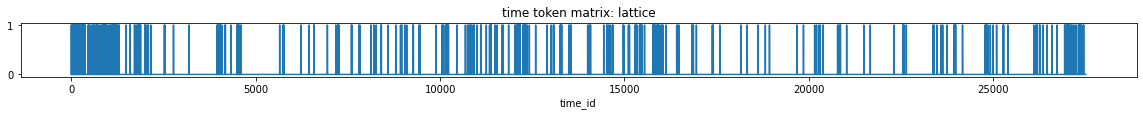

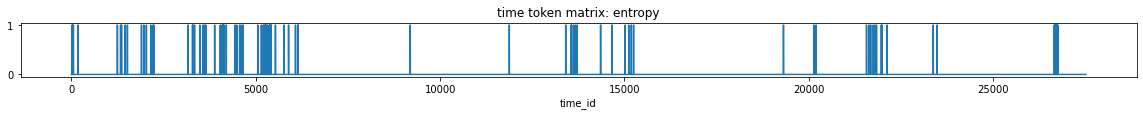

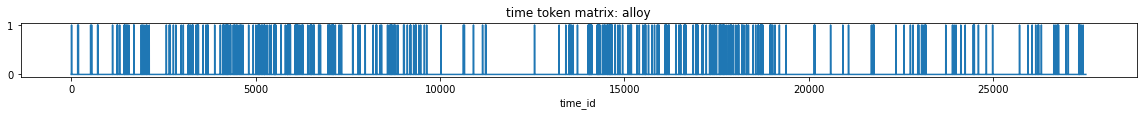

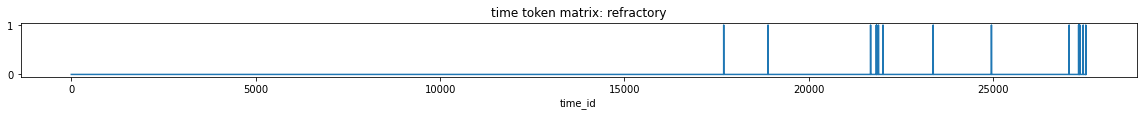

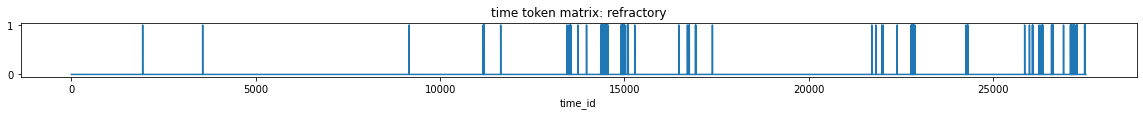

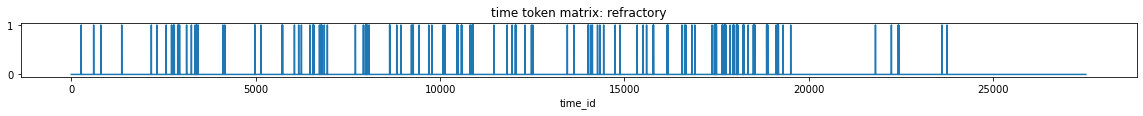

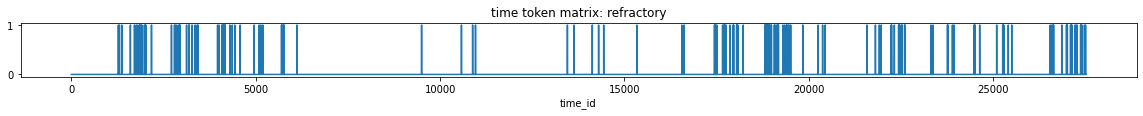

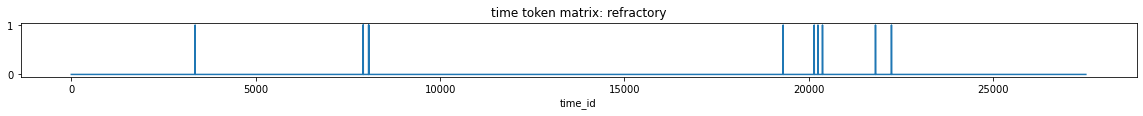

In [134]:
cfg = {'figsize':(20,1)}
TTM['lattice'].plot(**cfg)
plt.title('time token matrix: lattice')
plt.show()
TTM['entropy'].plot(**cfg)
plt.title('time token matrix: entropy')
plt.show()
TTM['alloy'].plot(**cfg)
plt.title('time token matrix: alloy')
plt.show()
TTM['refractory'].plot(**cfg)
plt.title('time token matrix: refractory')
plt.show()
TTM['hardness'].plot(**cfg)
plt.title('time token matrix: refractory')
plt.show()
TTM['fcc'].plot(**cfg)
plt.title('time token matrix: refractory')
plt.show()
TTM['bcc'].plot(**cfg)
plt.title('time token matrix: refractory')
plt.show()
TTM['hcp'].plot(**cfg)
plt.title('time token matrix: refractory')
plt.show()


Dispersion plot

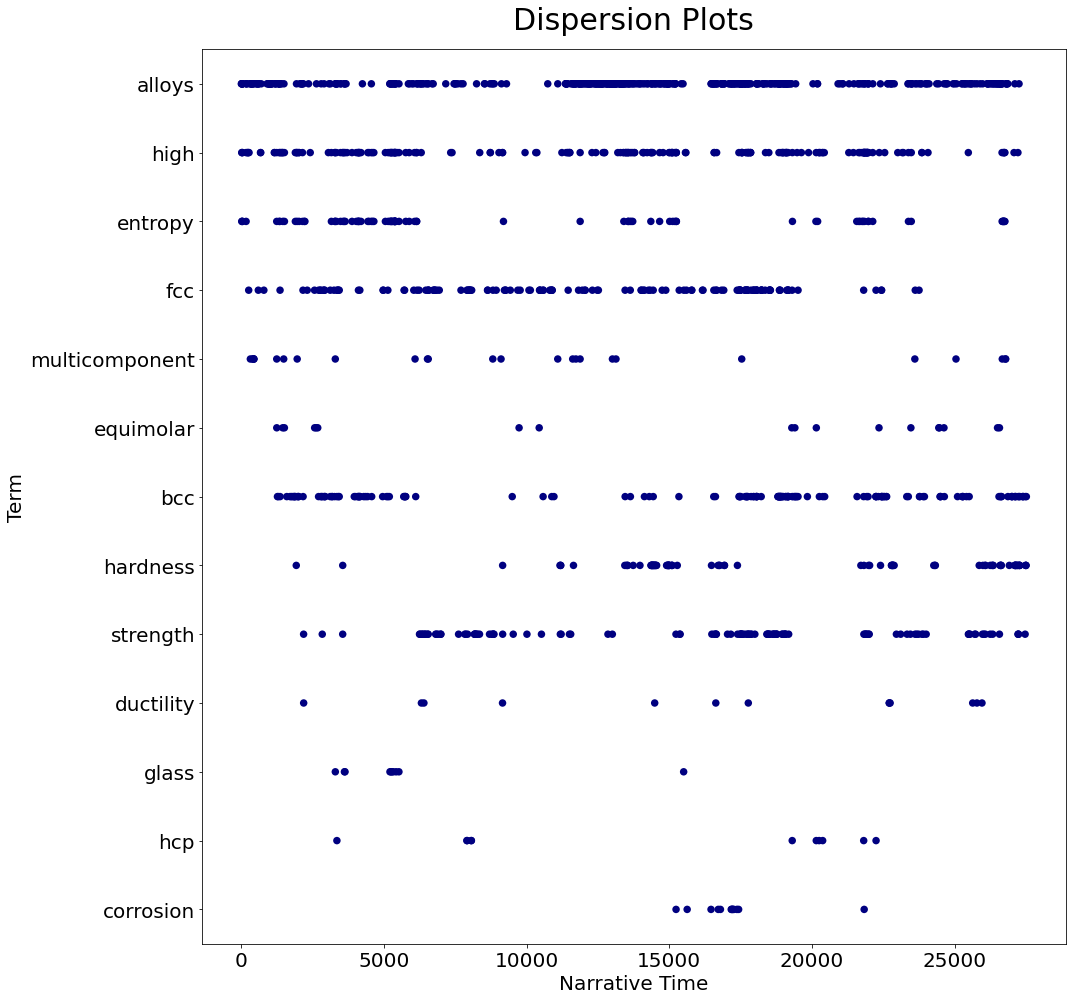

In [135]:
B = TOKENS['term_str'].reset_index(drop=True).to_frame().reset_index().rename(columns={'index':'offset'})
names = ['bcc', 'fcc', 'hcp', 'high', 'strength', 'ductility', 'entropy', 'alloys', 'equimolar', 'multicomponent', 'hardness', 'corrosion', 'multicomponent', 'glass']
X = B[B.term_str.isin(names)]
plt.figure(figsize=(15, len(names)))
ax = sns.stripplot(y='term_str', x='offset', data=X, orient='h', marker=".", color='navy', size=15, jitter=0)
ax.set_title('Dispersion Plots', size=30, pad=20)
ax.set_xlabel('Narrative Time', size=20)
ax.set_ylabel('Term', size=20)
    
plt.xticks(rotation=0, fontsize=20)
plt.yticks(rotation=0, fontsize=20)
plt.tight_layout()

Offset plot

Text(0, 0.5, 'No. of Occurances')

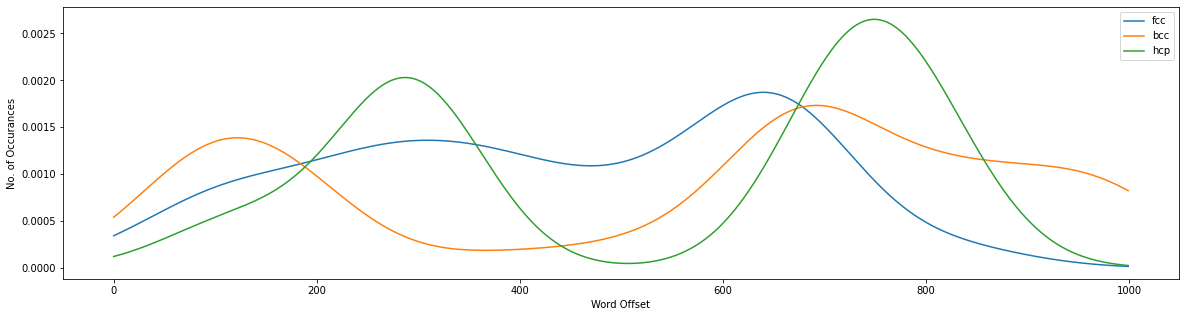

In [29]:
kde_kernel = 'gaussian'
kde_bandwidth = 2000
kde_samples = 1000

X = B.reset_index().groupby(['term_str']).offset.apply(lambda x: x.tolist()).to_frame()
X['x'] = X.apply(lambda x: np.array(x.offset)[:, np.newaxis], 1)
scale_max = B.offset.max() # THIS IS CRUCIAL
x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
X['kde'] = X.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
X['scores'] = X.apply(lambda row: row.kde.score_samples(x_axis), axis=1)
PLOTS = X.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1)

FIG = dict(figsize=(20, 5))
PLOTS.loc['fcc'].plot(**FIG, legend=True);
PLOTS.loc['bcc'].plot(**FIG, legend = True);
PLOTS.loc['hcp'].plot(**FIG, legend = True);
plt.xlabel('Word Offset')
plt.ylabel('No. of Occurances')

In [140]:
LIB.to_csv( 'final/LIB.csv' ) 
TOKENS.to_csv( 'final/TOKENS.csv' ) 
VOCAB.to_csv( 'final/VOCAB.csv' )

# TFIDF, DFIDF, BOW calculation

In [137]:
parg_bow = getBOW(TOKENS, ['doc_id', 'parg_num'])

In [138]:
TF, DF, IDF, TFIDF = getTFIDF( parg_bow, 'sum' )

In [144]:
VOCAB['df'] = DF
VOCAB['idf'] = IDF
VOCAB['tfidf_mean'] = TFIDF[TFIDF>0].mean().fillna(0)
VOCAB['tfidf_max'] = TFIDF.max()
VOCAB['dfidf'] = VOCAB['df'] * VOCAB['idf']
parg_bow['tf'] = TF.stack()
parg_bow['tfidf'] = TFIDF.stack()

In [145]:
VOCAB.head()

,n,p,i,h,n_chars,max_pos,stem_porter,stem_snowball,stem_lancaster,df,idf,tfidf_mean,tfidf_max,dfidf
term_str,,,,,,,,,,,,,,
alloys,482,0.017520,5.834832,0.102228,6,NNS,alloy,alloy,alloy,163,0.274951,0.009354,0.049991,44.816976
alloy,374,0.013595,6.200827,0.084298,5,NN,alloy,alloy,alloy,160,0.283018,0.007730,0.035377,45.282943
lattice,367,0.013340,6.228085,0.083083,7,NN,lattic,lattic,lat,136,0.353599,0.011216,0.040577,48.089528
phase,270,0.009814,6.670905,0.065470,5,NN,phase,phase,phas,88,0.542656,0.015971,0.056137,47.753702
high,218,0.007924,6.979537,0.055307,4,JJ,high,high,high,109,0.449712,0.010219,0.039105,49.018595


In [143]:
parg_bow.head()

n        tf     tfidf
doc_id parg_num term_str                       
0      0        alloy     1  0.016129  0.004565
                alloying  1  0.016129  0.012304
                alloys    8  0.129032  0.035478
                atomic    1  0.016129  0.009597
                based     1  0.016129  0.013450

Use the siginificant words for the analysis with 0.9 percentile of dfidf for the cutoff and interested pos gruops

In [146]:
cut_off = VOCAB['dfidf'].quantile(.9)
pos_list = "NN NNS VB VBD VBG VBN VBP VBZ JJ JJR JJS RB RBR RBS".split() # Open categories with no proper nouns
SIGS = (VOCAB['dfidf'] >= cut_off) & (VOCAB.max_pos.isin(pos_list))
VOCAB_SHORT = VOCAB.loc[SIGS]
VOCAB_SHORT

,n,p,i,h,n_chars,max_pos,stem_porter,stem_snowball,stem_lancaster,df,idf,tfidf_mean,tfidf_max,dfidf
term_str,,,,,,,,,,,,,,
alloys,482,0.017520,5.834832,0.102228,6,NNS,alloy,alloy,alloy,163,0.274951,0.009354,0.049991,44.816976
alloy,374,0.013595,6.200827,0.084298,5,NN,alloy,alloy,alloy,160,0.283018,0.007730,0.035377,45.282943
lattice,367,0.013340,6.228085,0.083083,7,NN,lattic,lattic,lat,136,0.353599,0.011216,0.040577,48.089528
phase,270,0.009814,6.670905,0.065470,5,NN,phase,phase,phas,88,0.542656,0.015971,0.056137,47.753702
high,218,0.007924,6.979537,0.055307,4,JJ,high,high,high,109,0.449712,0.010219,0.039105,49.018595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
previously,8,0.000291,11.747721,0.003416,10,RB,previous,previous,prevy,8,1.584048,0.016164,0.037715,12.672387
suggested,8,0.000291,11.747721,0.003416,9,VBN,suggest,suggest,suggest,8,1.584048,0.028179,0.105603,12.672387
combined,8,0.000291,11.747721,0.003416,8,VBN,combin,combin,combin,8,1.584048,0.015526,0.044001,12.672387


In [148]:
TFIDF = parg_bow.tfidf.unstack(fill_value=0)
TFIDF = TFIDF[VOCAB_SHORT.index]
TFIDF = TFIDF.groupby('doc_id').mean()
TFIDF # save0506

term_str,alloys,alloy,lattice,phase,high,bcc,elements,temperature,heas,fcc,...,vickers,added,microstructural,hard,overall,previously,suggested,combined,disorder,gives
doc_id,,,,,,,,,,,,,,,,,,,,,
0,0.009511,0.002390,0.024397,0.001049,0.004894,0.000000,0.006512,0.002204,0.012125,0.001110,...,0.000000,0.000000,0.000000,0.003901,0.000000,0.001904,0.000000,0.000000,0.000000,0.000655
1,0.001840,0.006177,0.010486,0.007726,0.007736,0.010884,0.004605,0.000292,0.001435,0.000346,...,0.000000,0.000791,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.002072,0.002907,0.001525,0.005936,0.001098,0.003627,0.001810,0.008720,0.004556,0.004369,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001187,0.000000,0.001123,0.001600
3,0.003207,0.008779,0.001798,0.013333,0.007185,0.004190,0.002983,0.003138,0.000680,0.002826,...,0.000000,0.000000,0.001748,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.002673,0.004810,0.003087,0.000827,0.001706,0.000000,0.002137,0.003384,0.001597,0.004449,...,0.000000,0.000152,0.000000,0.000000,0.006346,0.000000,0.000000,0.000823,0.001175,0.000372
5,0.000325,0.003686,0.004277,0.009325,0.002196,0.000543,0.001430,0.003601,0.002192,0.004220,...,0.001195,0.000379,0.000000,0.000152,0.000000,0.000000,0.000365,0.000525,0.000000,0.000000
6,0.016316,0.000534,0.006869,0.001861,0.002905,0.000000,0.001916,0.001139,0.000000,0.001385,...,0.000000,0.000000,0.000000,0.000000,0.000236,0.000000,0.000579,0.000402,0.000672,0.000000
7,0.006461,0.006643,0.003808,0.012826,0.009458,0.001082,0.003597,0.001517,0.002284,0.002714,...,0.001966,0.000589,0.000493,0.002031,0.000000,0.000725,0.000000,0.000000,0.000000,0.001643
8,0.001523,0.006341,0.010325,0.001421,0.001663,0.000331,0.003501,0.008439,0.005278,0.002420,...,0.000000,0.000000,0.000000,0.003251,0.000000,0.000000,0.001000,0.000000,0.003502,0.000000


In [152]:
PAIRS = 1 - TFIDF.T.corr().stack().to_frame('corr_raw')
PAIRS.index.names = ['doc_a', 'doc_b']
PAIRS = PAIRS.query('doc_a > doc_b' )
combos  = [
    (TFIDF, 'cityblock', 'cityblock–raw'),
    (TFIDF, 'euclidean', 'euclidean–raw'),
    (TFIDF, 'cosine', 'cosine–raw'),
]
for X, metric, label in combos:
    PAIRS[label] = pdist(X, metric)
ZPAIRS = (PAIRS - PAIRS.mean()) / PAIRS.std()

In [151]:
PAIRS.head(20).style.background_gradient(cmap='YlGnBu', high=.5, axis=0)

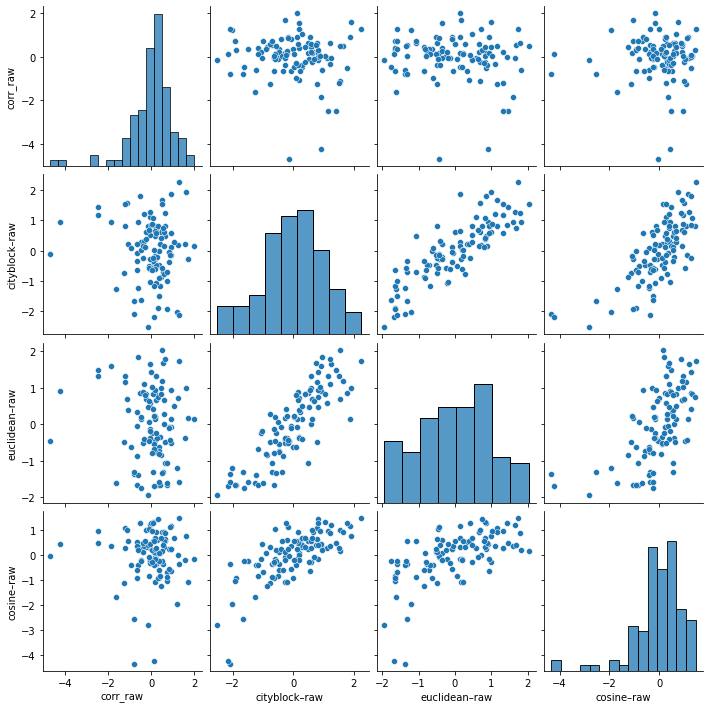

In [153]:
sns.pairplot(ZPAIRS);

<Figure size 432x288 with 0 Axes>

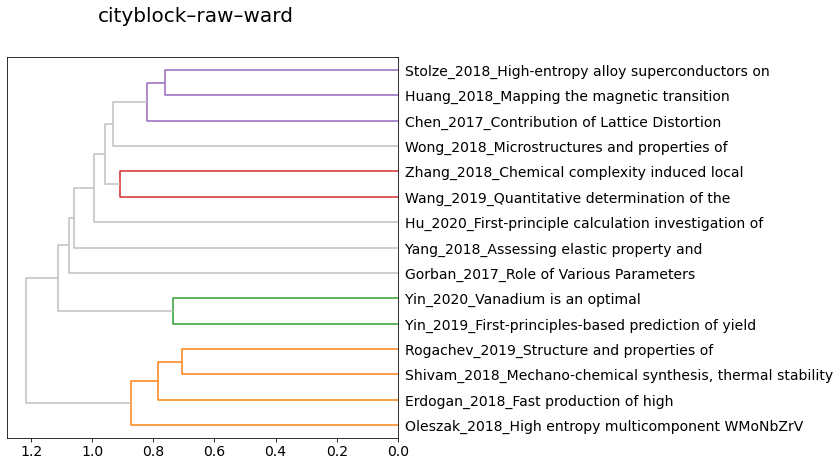

<Figure size 432x288 with 0 Axes>

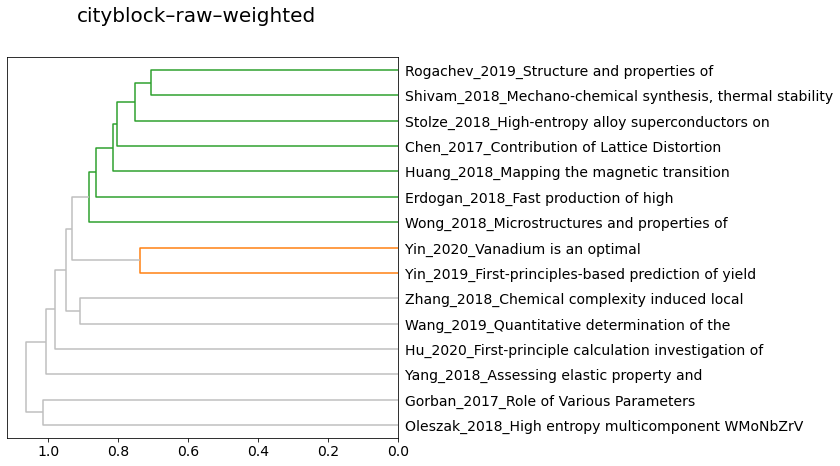

<Figure size 432x288 with 0 Axes>

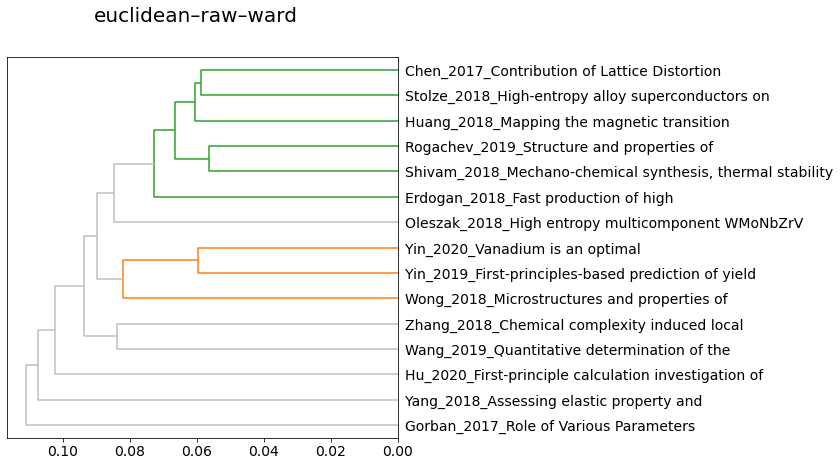

<Figure size 432x288 with 0 Axes>

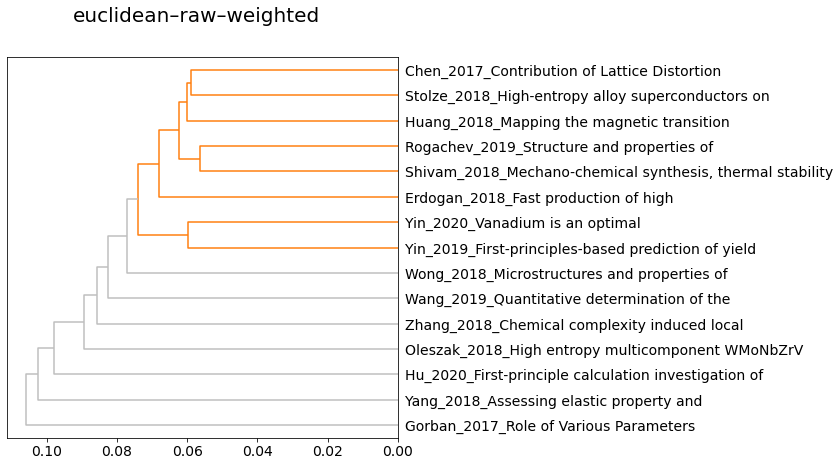

<Figure size 432x288 with 0 Axes>

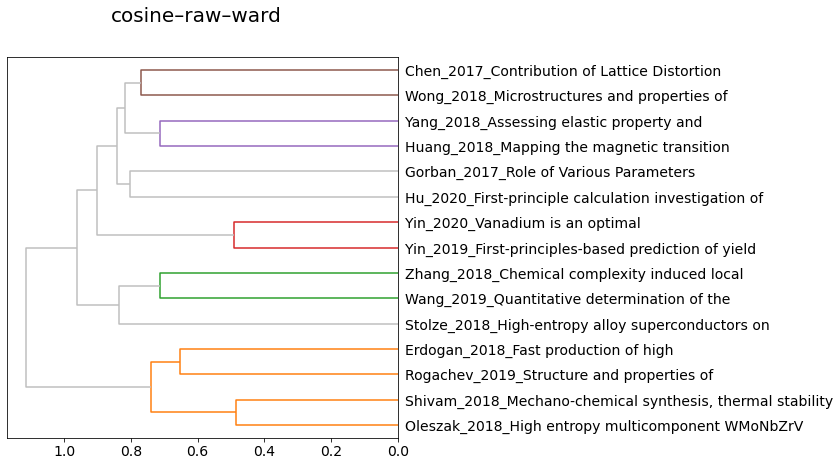

<Figure size 432x288 with 0 Axes>

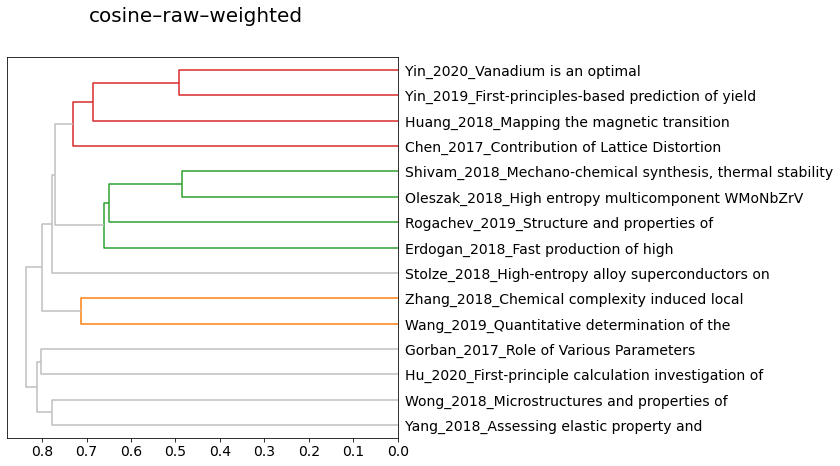

In [156]:
for combo in combos:
    m = combo[-1]
    for l in ['ward','weighted']:
        title = f"{m}–{l}"
        hca(PAIRS[m], title, linkage_method=l)

In [157]:
n_clusters = 4
km = KMeans(n_clusters)
LIB['y_raw'] = km.fit_predict(TFIDF)
LIB.iloc[:, 1:].style.background_gradient(cmap='YlGn') # save0506

,title,publisher,year,paper_len,num_parg,label,y_raw
0,Quantitative determination of the lattice constant in high entropy alloys,Scripta Materialia,2019,1242,13,Wang_2019_Quantitative determination of the,1
1,High entropy multicomponent WMoNbZrV alloy processed by mechanical alloying,Materials Letters,2018,796,14,Oleszak_2018_High entropy multicomponent WMoNbZrV,2
2,Mapping the magnetic transition temperatures for medium- and highentropy alloy,Intermetallics,2018,1123,15,Huang_2018_Mapping the magnetic transition,1
3,"Mechano-chemical synthesis, thermal stability and phase evolution in AlCoCrFeNiMn high entropy alloy",Journal of Alloys and Compounds,2018,3029,24,"Shivam_2018_Mechano-chemical synthesis, thermal stability",2
4,First-principles-based prediction of yield strength in the RhIrPdPtNiCu high-entropy alloy,Computational Materials,2019,2838,30,Yin_2019_First-principles-based prediction of yield,1
5,Structure and properties of equiatomic CoCrFeNiMn alloy fabricated by high-energy ball milling and spark plasma sintering,Journal of Alloys and Compounds,2019,2324,26,Rogachev_2019_Structure and properties of,2
6,"Assessing elastic property and solid-solution strengthening of binary Ni–Co, Ni–Cr, and ternary Ni–Co–Cr alloys from first-principles theory",Journal of Materials Research,2018,2045,18,Yang_2018_Assessing elastic property and,1
7,Fast production of high entropy alloys (CoCrFeNiAlxTiy) by electric current activated sintering system,Vacuum,2018,1733,21,Erdogan_2018_Fast production of high,2
8,Chemical complexity induced local structural distortion in NiCoFeMnCr high-entropy alloy,Materials Research Letters,2018,1321,11,Zhang_2018_Chemical complexity induced local,1
9,Microstructures and properties of Al0.3CoCrFeNiMnx high-entropy alloys,Materials Chemistry and Physics,2018,977,12,Wong_2018_Microstructures and properties of,1


# PCA analysis

In [158]:
## PCA
# normalize doc vector length
TFIDF = TFIDF.apply(lambda x: x / norm(x), 1).fillna(0) # euclidean norm
TFIDF = TFIDF - TFIDF.mean() # center 
TFIDF = TFIDF / TFIDF.std() # normalize variance
cov = TFIDF.cov()

In [159]:
k = 6 # number of components
w, v = eigh(cov, subset_by_index=(len(cov)-k, len(cov)-1))
pc_ids = list(reversed([i for i in range(k)]))
C = pd.DataFrame(w, columns=['eig_val'])
C.index = pc_ids
C = C.sort_index()
C.index.name = 'pc_id'
C['exp_var'] = C.eig_val / C.eig_val.sum()

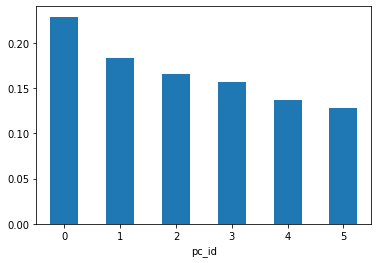

In [160]:
C.exp_var.plot.bar(rot=0)

In [161]:
L = pd.DataFrame(v, index=cov.index)
L.columns = pc_ids
L = L.T.sort_index().T
L.columns.name = 'pc_id'

In [162]:
L.sample(20).style.background_gradient(cmap='GnBu', high=0.5)

pc_id,0,1,2,3,4,5
term_str,,,,,,
prediction,-0.102382,0.008952,-0.033488,-0.051764,-0.030118,0.002540
listed,0.005833,0.039328,0.055966,0.035752,-0.037619,-0.029918
strengths,-0.069111,0.015978,-0.009714,-0.053926,-0.044751,-0.002325
enthalpy,0.025322,0.030371,0.014778,0.019610,0.019005,-0.010157
conducted,0.032298,-0.015606,0.016524,-0.027398,0.023944,-0.030643
increasing,-0.021629,-0.032732,-0.020098,0.075800,-0.046692,-0.015277
formed,0.055399,0.013130,-0.019758,-0.034696,0.060517,-0.032014
account,-0.013433,-0.118165,0.048851,0.019982,0.024673,0.019745
tensile,0.009994,0.029076,0.040940,-0.003151,-0.000349,-0.082587


In [163]:
DCM = TFIDF.dot(L)
DCM.sample(15).style.background_gradient(cmap='GnBu', high=0.5)

pc_id,0,1,2,3,4,5
doc_id,,,,,,
12,-0.987965,4.456267,3.671950,1.923931,5.748952,-1.885250
13,-1.934435,-24.185481,10.622811,1.273601,1.411884,1.068282
2,-9.393979,-2.772151,-13.958293,5.869473,14.490569,2.987070
9,1.934474,5.491139,7.446880,-0.296809,-0.039336,-11.715955
8,2.128596,3.425976,2.777321,6.017063,-2.129563,7.195494
5,6.291996,-1.204168,-2.647183,-5.766457,3.305983,-5.319317
6,-3.353927,6.431344,6.337123,6.177165,3.024750,2.542398
10,-9.310557,3.196045,-0.248708,-5.505893,-4.205700,0.381579
7,7.040871,-0.037027,0.583861,-6.762588,4.759361,-8.254208


In [164]:
top_n = 6 # Number of top words for each pole
for i in range(k):
    for j, pole in enumerate(['neg','pos']):
        top_terms = ' '.join(L.sort_values(i, ascending=bool(j)).head(top_n).index.to_list())
        C.loc[i, pole] = top_terms

In [165]:
C

,eig_val,exp_var,neg,pos
pc_id,,,,
0,69.932975,0.228960,entropy patterns powder phase diameter xrd,calculations prediction law vegards prediction...
1,55.980423,0.183279,therefore results solid-solution effect smalle...,hence several radii compression slip nbmocrtial
2,50.541735,0.165473,alloys hardening identified reference mean stress,carried structural interest disordered systems...
3,48.070964,0.157384,low critical transition trend zero dependence,alloy also literature leads stable formation
4,41.935875,0.137298,seen theoretical radius according magnetic bec,crystalline different previously still describ...
5,38.975922,0.127607,alloying revealed corresponding multicomponent...,sem properties eds due high-entropy applied


In [166]:
LIB = LIB.join(DCM)

In [193]:
LIB

,author,title,publisher,year,paper_len,num_parg,label,y_raw,0,1,2,3,4,5
0,Zhijun Wang,Quantitative determination of the lattice cons...,Scripta Materialia,2019,1242,13,Wang_2019_Quantitative determination of the,1,-2.555158,3.279425,6.595217,4.280000,-7.774376,7.018712
1,Dariusz Oleszak,High entropy multicomponent WMoNbZrV alloy pro...,Materials Letters,2018,796,14,Oleszak_2018_High entropy multicomponent WMoNbZrV,2,9.216617,2.558165,-1.733476,-2.829823,1.817494,9.328328
2,Shuo Huang,Mapping the magnetic transition temperatures f...,Intermetallics,2018,1123,15,Huang_2018_Mapping the magnetic transition,1,-9.393979,-2.772151,-13.958293,5.869473,14.490569,2.987070
3,Vikas Shivam,"Mechano-chemical synthesis, thermal stability ...",Journal of Alloys and Compounds,2018,3029,24,"Shivam_2018_Mechano-chemical synthesis, therma...",2,12.180536,-2.311174,-6.768533,-11.765481,-4.134131,6.737289
4,Binglun Yin,First-principles-based prediction of yield str...,Computational Materials,2019,2838,30,Yin_2019_First-principles-based prediction of ...,1,-20.237438,0.583843,-3.551809,-9.755490,-6.590758,-1.573035
5,A.S. Rogachev,Structure and properties of equiatomic CoCrFeN...,Journal of Alloys and Compounds,2019,2324,26,Rogachev_2019_Structure and properties of,2,6.291996,-1.204168,-2.647183,-5.766457,3.305983,-5.319317
6,Zhi-biao Yang,Assessing elastic property and solid-solution ...,Journal of Materials Research,2018,2045,18,Yang_2018_Assessing elastic property and,1,-3.353927,6.431344,6.337123,6.177165,3.024750,2.542398
7,Azmi Erdogan,Fast production of high entropy alloys (CoCrFe...,Vacuum,2018,1733,21,Erdogan_2018_Fast production of high,2,7.040871,-0.037027,0.583861,-6.762588,4.759361,-8.254208
8,Fuxiang Zhang,Chemical complexity induced local structural d...,Materials Research Letters,2018,1321,11,Zhang_2018_Chemical complexity induced local,1,2.128596,3.425976,2.777321,6.017063,-2.129563,7.195494
9,Sze-Kwan Wong,Microstructures and properties of Al0.3CoCrFeN...,Materials Chemistry and Physics,2018,977,12,Wong_2018_Microstructures and properties of,1,1.934474,5.491139,7.446880,-0.296809,-0.039336,-11.715955


In [168]:
px.scatter(LIB, 0, 1, 
           color='author', symbol='title', 
           hover_name='label', 
           marginal_x='box', marginal_y='box', 
           height=1000)

In [169]:
VOCAB2 = VOCAB.join(L, how='right').reset_index()

In [170]:
px.scatter(VOCAB2, 0, 1, 
           size='tfidf_mean', color='dfidf', 
           hover_name='term_str', 
           hover_data=['max_pos'], 
           marginal_x='box', marginal_y='box', 
           height=1000, width=1000)

In [171]:
BCM = DCM.groupby('doc_id').mean().sort_index()
BCM.index = LIB.loc[list(BCM.index)].label

In [172]:
px.bar(BCM.sort_values(0), height=1000, orientation='h', barmode='relative')

hierarchical clustering on the principal components

<Figure size 432x288 with 0 Axes>

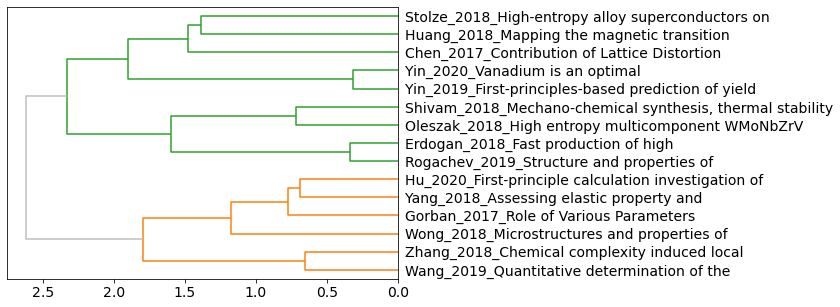

In [174]:
dend1 = HAC(BCM)
dend1.w = 7
dend1.color_thresh = 2.5
dend1.plot()

In [174]:
# C is PCA_COMPS
# L is PCA_THETA
# DCM is PCA_DCM

# Topic model

In [175]:
## Topic models
n_topics = 10
n_terms = 4000
tm = TopicModel(getBOW(TOKENS, ['doc_id']))
tm.engine_type = 'LDA'
tm.n_topics = n_topics
tm.n_terms = n_terms
tm.create_X()
tm.get_model()
tm.describe_topics()
tm.get_model_stats()

<Figure size 2880x720 with 0 Axes>

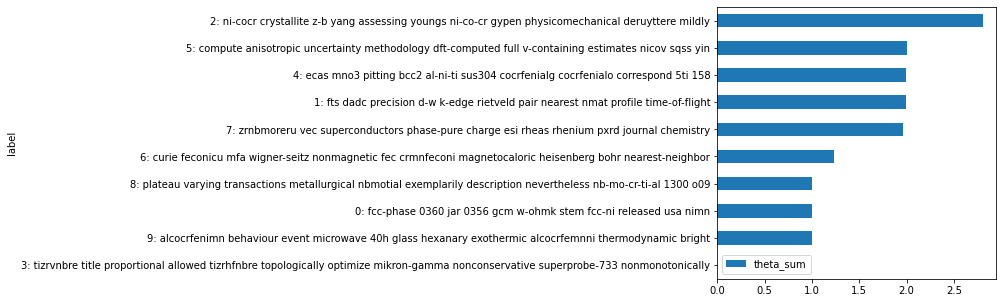

In [176]:
plt.figure(figsize=(40,10))
tm.plot_topics()

In [177]:
tm_img = tm.THETA.groupby('doc_id').mean()
tm_img.index = LIB.label
tm_img.columns = tm.TOPIC.label

In [178]:
tm_img.T.style.background_gradient(cmap='GnBu')

label,Wang_2019_Quantitative determination of the,Oleszak_2018_High entropy multicomponent WMoNbZrV,Huang_2018_Mapping the magnetic transition,"Shivam_2018_Mechano-chemical synthesis, thermal stability",Yin_2019_First-principles-based prediction of yield,Rogachev_2019_Structure and properties of,Yang_2018_Assessing elastic property and,Erdogan_2018_Fast production of high,Zhang_2018_Chemical complexity induced local,Wong_2018_Microstructures and properties of,Yin_2020_Vanadium is an optimal,Stolze_2018_High-entropy alloy superconductors on,Hu_2020_First-principle calculation investigation of,Chen_2017_Contribution of Lattice Distortion,Gorban_2017_Role of Various Parameters
label,,,,,,,,,,,,,,,
0: fcc-phase 0360 jar 0356 gcm w-ohmk stem fcc-ni released usa nimn,0.000260,0.000347,0.000215,0.000091,0.000091,0.999073,0.000170,0.000169,0.000196,0.000248,0.000169,0.000090,0.000176,0.000072,0.000417
1: fts dadc precision d-w k-edge rietveld pair nearest nmat profile time-of-flight,0.997656,0.000347,0.000215,0.000091,0.000092,0.000103,0.000170,0.000169,0.998232,0.000248,0.000169,0.000090,0.000176,0.000072,0.000417
2: ni-cocr crystallite z-b yang assessing youngs ni-co-cr gypen physicomechanical deruyttere mildly,0.000260,0.996875,0.000215,0.003365,0.000091,0.000103,0.808593,0.000169,0.000196,0.000248,0.000169,0.000090,0.000176,0.000072,0.996250
3: tizrvnbre title proportional allowed tizrhfnbre topologically optimize mikron-gamma nonconservative superprobe-733 nonmonotonically,0.000260,0.000347,0.000215,0.000091,0.000091,0.000103,0.000170,0.000169,0.000196,0.000248,0.000169,0.000090,0.000176,0.000072,0.000417
4: ecas mno3 pitting bcc2 al-ni-ti sus304 cocrfenialg cocrfenialo correspond 5ti 158,0.000260,0.000347,0.000215,0.000091,0.000091,0.000103,0.000170,0.998477,0.000196,0.997767,0.000169,0.000090,0.000176,0.000072,0.000417
5: compute anisotropic uncertainty methodology dft-computed full v-containing estimates nicov sqss yin,0.000260,0.000347,0.000215,0.000091,0.999177,0.000103,0.000170,0.000169,0.000196,0.000248,0.998482,0.000090,0.000176,0.000072,0.000417
6: curie feconicu mfa wigner-seitz nonmagnetic fec crmnfeconi magnetocaloric heisenberg bohr nearest-neighbor,0.000260,0.000347,0.998064,0.000091,0.000091,0.000103,0.190046,0.000169,0.000196,0.000248,0.000169,0.000090,0.039019,0.000072,0.000417
7: zrnbmoreru vec superconductors phase-pure charge esi rheas rhenium pxrd journal chemistry,0.000260,0.000347,0.000215,0.000091,0.000091,0.000103,0.000170,0.000169,0.000196,0.000248,0.000169,0.999188,0.959572,0.000072,0.000417
8: plateau varying transactions metallurgical nbmotial exemplarily description nevertheless nb-mo-cr-ti-al 1300 o09,0.000260,0.000347,0.000215,0.000091,0.000091,0.000103,0.000170,0.000169,0.000196,0.000248,0.000169,0.000090,0.000176,0.999353,0.000417


In [179]:
fig = px.imshow(tm_img.T, color_continuous_scale='GnBu', title="High Entropy literatures", height=1000)
fig.update_layout(xaxis={'side': 'top', 'title_text':None}, yaxis={'title_text':None})

<Figure size 432x288 with 0 Axes>

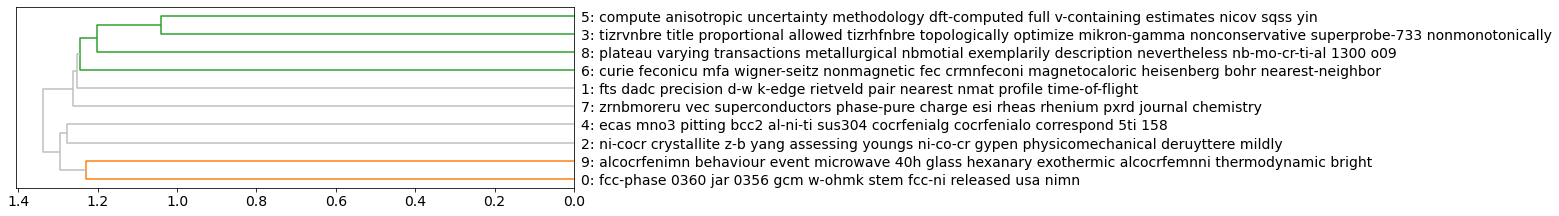

In [180]:
# topic dendrogram
topic_dend = HAC(tm.PHI)
topic_dend.labels = tm.TOPIC.label.to_list()
topic_dend.plot()

# Word2Vex

In [182]:
HEAs = W2V(TOKENS, ['parg_num', 'sent_num'], ['parg_num', 'sent_num'])
HEAs.w2v_args['min_count'] = 50
HEAs.w2v_args['vector_size'] = 256 
HEAs.tsne_args['perplexity'] = 20
HEAs.tsne_args['random_state'] = 111
HEAs.generate_model();

W2V Bag: sent_num
DOC Bag: sent_num
Extracting vocabulary
Gathering sentences
Learning word vectors
Estimating tSNE coordinates
Done ✓


In [183]:
px.scatter(HEAs.TSNE.reset_index(), 'x', 'y', 
           color='pos_group', text='term_str',
           hover_name='term_str',
           size=np.log2(HEAs.TSNE.n),
           height=1000, width=1200)

In [184]:
HEAs.TSNE['n2'] = np.log2(HEAs.TSNE.n)
HEAs.plot_tsne(n=2000, method='sample')

analogy computation

In [185]:
HEAs.complete_analogy('structure','properties','fcc', 10)

,term,sim
0,alloys,0.999193
1,alloy,0.999097
2,elements,0.999057
3,high,0.999021
4,solid,0.999009
5,method,0.998989
6,size,0.998983
7,values,0.998977
8,strengthening,0.998971
9,lattice,0.998970


In [186]:
HEAs.complete_analogy('structure','properties','bcc', 10)

,term,sim
0,alloys,0.999103
1,alloy,0.999084
2,solid,0.999014
3,high,0.998992
4,size,0.998977
5,values,0.998957
6,lattice,0.998952
7,elements,0.998950
8,mechanical,0.998942
9,atomic,0.998934


similar words

In [187]:
HEAs.get_most_similar('bcc')

,term,sim
0,alloys,0.999526
1,alloy,0.999509
2,lattice,0.999468
3,phase,0.999451
4,found,0.999448
5,heas,0.999440
6,size,0.999427
7,high,0.999426
8,hardness,0.999420
9,mpa,0.999401


In [188]:
HEAs.get_most_similar('fcc')

,term,sim
0,alloys,0.999692
1,alloy,0.999598
2,phase,0.999572
3,lattice,0.999562
4,high,0.999532
5,using,0.999528
6,strengthening,0.999521
7,size,0.999509
8,heas,0.999501
9,elements,0.999500
